# GETTING AND PREPROCCESING THE DATA

In [167]:
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("stock_data.csv")
df['Text'] = df['Text'].str.replace(r'[^\w\s]+', '')
df["Sentiment"].replace(-1,0,inplace=True)
df

C:\Users\HARSHV~1\AppData\Local\Temp/ipykernel_7224/610565413.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace(r'[^\w\s]+', '')


,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user AAP MOVIE 55 return for the FEAGEED indic...,1
2,user Id be afraid to short AMZN they are look...,1
3,MNTA Over 1200,1
4,OI Over 2137,1
...,...,...
5786,Industry body CII said discoms are likely to s...,0
5787,Gold prices slip below Rs 46000 as investors b...,0
5788,Workers at Bajaj Auto have agreed to a 10 wage...,1
5789,Sharemarket LIVE Sensex off days high up 600 p...,1


In [2]:
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [3]:
x = df["Text"].to_numpy()
y = df["Sentiment"].to_numpy()
x = {
    "inputs":x
}
y = {
    "classifier_output":y
}

# BUILDING THE BERT MODEL

In [31]:
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = "preprocessor")
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True, name="encoder")

In [32]:
text_input = tf.keras.Input(shape=(), dtype=tf.string, name="inputs")
preprocessing = preprocessor(text_input)
encoded_outputs = encoder(preprocessing)
pooled_outputs = encoded_outputs["pooled_output"]
pooled_outputs = tf.keras.layers.Dropout(0.1, name="dropout")(pooled_outputs)
outputs = tf.keras.layers.Dense(1, activation="sigmoid",name="classifier_output")(pooled_outputs)
model = tf.keras.Model(text_input, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_type_ids':   0           ['inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [33]:
# testing the output
output = model(tf.constant(["Hello, how are you?"]))
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.73874414]], dtype=float32)>

In [34]:
for i, layers in enumerate(model.layers):
    print(i,layers.name,layers.trainable, layers.dtype)

0 inputs True string
1 preprocessor False float32
2 encoder True float32
3 dropout True float32
4 classifier_output True float32


# SPLITTING INTO TRAIN AND TEST DATA

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df["Text"], df["Sentiment"], 
                                                    shuffle=True, 
                                                    random_state=42)
x_train

3505          NS oad puts HF is about to get blown up imo
5033    RT AmrithRamkumar Just a staggering increase i...
3887                   CWBC  buying in new nano cap folio
2535    GEVO Good breakout on high volume  Possibly a ...
2707    GD ABX NEM DZZ AY   Deutsche Bank Today is an ...
                              ...                        
3772    AAP We break and close below this support 360 ...
5191    New industry data provide the first hard look ...
5226    RT JChengWSJ In hindsight Wall Street probably...
5390    Global stocks fall after President Trump issue...
860     HPQ how many upgrades tomorrow assuming Autono...
Name: Text, Length: 4343, dtype: object

# TRAINING THE MODEL

In [36]:
model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
# this cell was run 4 times which means that the model was trained on 20 epochs
history = model.fit(x_train, y_train,
                    batch_size=16, #since i am getting a resource exhausted error 
                    epochs=5)

Epoch 1/5
272/272 [==============================] - 109s 365ms/step - loss: 0.5688 - accuracy: 0.7020
Epoch 2/5
272/272 [==============================] - 100s 368ms/step - loss: 0.3940 - accuracy: 0.8236
Epoch 3/5
272/272 [==============================] - 101s 370ms/step - loss: 0.2526 - accuracy: 0.9065
Epoch 4/5
272/272 [==============================] - 101s 370ms/step - loss: 0.1684 - accuracy: 0.9434
Epoch 5/5
272/272 [==============================] - 104s 382ms/step - loss: 0.1289 - accuracy: 0.9563


In [37]:
model.evaluate(x_test,y_test)

46/46 [==============================] - 14s 280ms/step - loss: 0.7452 - accuracy: 0.8018


[0.7451506853103638, 0.8017956018447876]

In [38]:
model.save("model1")

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


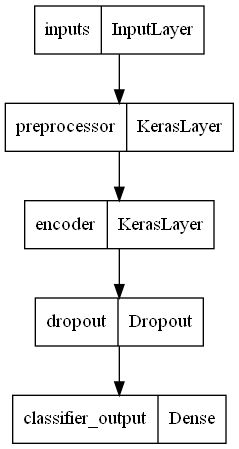

In [39]:
tf.keras.utils.plot_model(model)

# EVALUATING THE MODEL

In [57]:
preds = tf.squeeze(np.round(model.predict(x_test)).astype(np.int64)).numpy()

In [62]:
labels = y_test.to_numpy()
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)

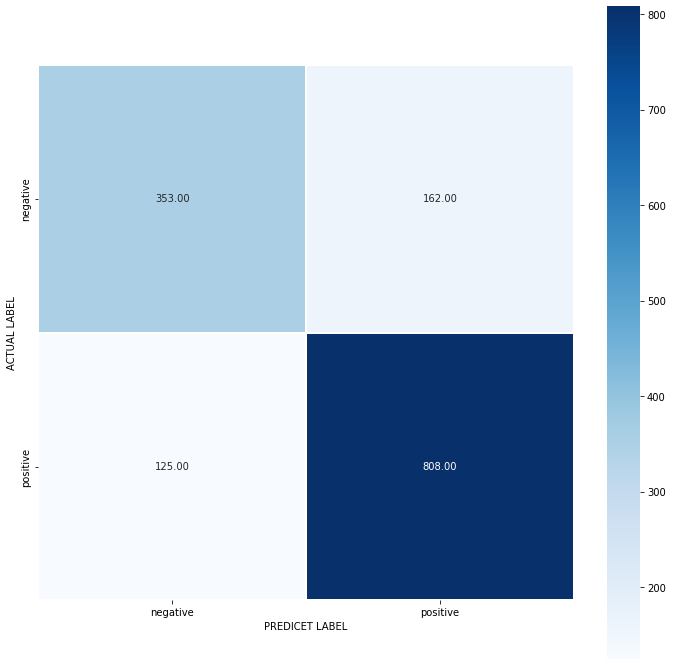

In [64]:
from helperfuncs import plot_confusion_matrix
plot_confusion_matrix(cm, class_names=["negative","positive"])

# MORE FINE TUNING

In [70]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                      patience=3,
                                     min_delta=0.1)
METRICS = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=METRICS)
history_ft = model.fit(x_train, y_train,
                       batch_size=16,x
                       epochs=15,
                       validation_data = (x_test,y_test))
#training halted in between

Epoch 1/15
272/272 [==============================] - 119s 418ms/step - loss: 0.0374 - binary_accuracy: 0.9878 - precision: 0.9902 - recall: 0.9906 - val_loss: 0.8597 - val_binary_accuracy: 0.8163 - val_precision: 0.8653 - val_recall: 0.8467
Epoch 2/15
272/272 [==============================] - 113s 416ms/step - loss: 0.0193 - binary_accuracy: 0.9949 - precision: 0.9982 - recall: 0.9938 - val_loss: 0.9483 - val_binary_accuracy: 0.8142 - val_precision: 0.8487 - val_recall: 0.8660
Epoch 3/15
272/272 [==============================] - 114s 418ms/step - loss: 0.0082 - binary_accuracy: 0.9984 - precision: 0.9989 - recall: 0.9985 - val_loss: 1.0706 - val_binary_accuracy: 0.8177 - val_precision: 0.8540 - val_recall: 0.8650
Epoch 4/15
272/272 [==============================] - 114s 421ms/step - loss: 0.0086 - binary_accuracy: 0.9984 - precision: 0.9989 - recall: 0.9985 - val_loss: 1.1459 - val_binary_accuracy: 0.8170 - val_precision: 0.8465 - val_recall: 0.8746
Epoch 5/15
272/272 [============

KeyboardInterrupt: 

# LOOKING AT SOME PREDICTIONS OF THE MODEL

In [162]:
import random
i = random.randint(0, len(x_test)-1)
prediction = tf.squeeze(np.round(model.predict([x_test.to_numpy()[i]])).astype(np.int64)).numpy()
print(f"THE POST: \n {x_test.to_numpy()[i]}")
print(f"PREDICTION: {prediction}")
print(f"TRUE LABEL: {y_test.to_numpy()[i]}")

THE POST: 
 user AAP cool comparisson between Galaxy S4 and Note 2  whatever the rules BTW Here is hoping for more action today 
PREDICTION: 1
TRUE LABEL: 1


In [132]:
model.save("model2")

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


# PLOTTING ROC CURVE

In [165]:
from sklearn.metrics import roc_curve
scores = tf.squeeze(model.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), scores)

Text(0.5, 1.0, 'ROC Curve')

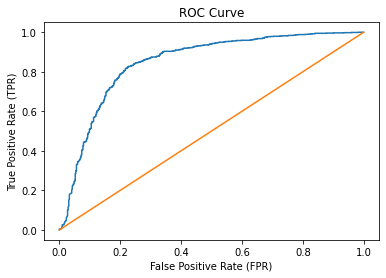

In [171]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")